In [138]:
from enum import Enum

class ClassDataType(Enum):
    COVID19 = 'COVID19'
    NORMAL = 'NORMAL'
    PNEUMONIA = 'PNEUMONIA'

In [139]:
import torch
from PIL import Image
from torchvision.transforms import v2


def load_img(path):
    img = Image.open(path).convert('RGB')
    img = v2.functional.to_image(img)
    img = v2.functional.to_dtype(img, dtype=torch.uint8, scale=True)
    return img

In [140]:
from typing import Callable

import kagglehub
import torch
import os

from torch import Tensor


class Config:
    NUM_EPOCHS = 50
    BATCH_SIZE = 32
    LEARNING_RATE = 0.01
    PATIENCE = 10

    IMG_SIZE = 224
    TRAIN_SPLIT_RATIO = 0.8

    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    NUM_WORKERS = os.cpu_count() // 2 if os.cpu_count() else 4

    MODEL_SAVE_DIR = "models"
    REPORTS_DIR = "reports"
    TENSORBOARD_DIR = "runs"

    def __init__(self, download_path: str, batch_size: int = BATCH_SIZE, learning_rate: float = LEARNING_RATE):
        os.environ['KAGGLEHUB_CACHE'] = download_path
        dataset_dir = kagglehub.dataset_download("alsaniipe/chest-x-ray-image")

        self.processed_data_dir = f"{download_path}/processed"
        self.base_dir = f"{dataset_dir}/Data"

        self.train_dir = os.path.join(self.base_dir, 'train')
        self.test_dir = os.path.join(self.base_dir, 'test')
        self.batch_size = batch_size
        self.learning_rate = learning_rate


    def qtd_images_train(self) -> tuple[int, int, int]:
        return self.qtd_images_dir(self.train_dir)

    def qtd_images_test(self) -> tuple[int, int, int]:
        return self.qtd_images_dir(self.test_dir)

    def class_weights_train(self) -> Tensor:
        return self.class_weights(self.qtd_images_train)

    def class_weights_test(self) -> Tensor:
        return self.class_weights(self.qtd_images_test)

    def class_weights(self, func: Callable[[], tuple[int, int, int]]) -> Tensor:
        qtd_num_covid, qtd_num_normal, qtd_num_pneumonia = func()
        print(f"Covid: {qtd_num_covid}, Normal: {qtd_num_normal}, Pneumonia: {qtd_num_pneumonia}")

        weight_covid = 1.0 / qtd_num_covid
        weight_normal = 1.0 / qtd_num_normal
        weight_pneumonia = 1.0 / qtd_num_pneumonia

        total_weight = weight_covid + weight_normal + weight_pneumonia

        return torch.tensor([
            weight_covid / total_weight,
            weight_normal / total_weight,
            weight_pneumonia / total_weight
        ]).to(self.DEVICE)

    @staticmethod
    def qtd_images_dir(dataset_dir: str) -> tuple[int, int, int]:
        covid_path = os.path.join(dataset_dir, 'COVID19')
        normal_path = os.path.join(dataset_dir, 'NORMAL')
        pneumonia_path = os.path.join(dataset_dir, 'PNEUMONIA')

        qtd_num_covid = len(os.listdir(covid_path))
        qtd_num_normal = len(os.listdir(normal_path))
        qtd_num_pneumonia = len(os.listdir(pneumonia_path))

        return qtd_num_covid, qtd_num_normal, qtd_num_pneumonia

In [141]:
from torchvision.transforms import v2
from tqdm import tqdm


class Preprocessor:
    def __init__(self, config: Config):
        self.config = config
        self.img_size = config.IMG_SIZE
        self.source_base_dir = config.base_dir
        self.target_base_dir = config.processed_data_dir

    def run(self, padding: int = 32):

        resize_transform = v2.Resize((self.img_size + padding, self.img_size + padding))

        print(f"Iniciando pré-processamento de '{self.config.base_dir}' para '{self.config.processed_data_dir}'...")

        for split in ['train', 'val', 'test']:
            source_dir = os.path.join(self.source_base_dir, split)
            target_dir = os.path.join(self.target_base_dir, split)

            if not os.path.isdir(source_dir):
                continue

            all_paths = [
                os.path.join(dirpath, filename)
                for dirpath, _, filenames in os.walk(source_dir)
                for filename in filenames
                if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))
            ]

            if not all_paths:
                continue

            for img_path in tqdm(all_paths, desc=f"running {split}"):
                relative_path = os.path.relpath(img_path, source_dir)
                target_img_path = os.path.join(target_dir, os.path.splitext(relative_path)[0] + '.png')

                if os.path.exists(target_img_path):
                    continue

                try:
                    os.makedirs(os.path.dirname(target_img_path), exist_ok=True)

                    img_tensor = load_img(img_path)
                    img_resized = resize_transform(img_tensor)

                    pil_img = v2.functional.to_pil_image(img_resized)
                    pil_img.save(target_img_path)

                except Exception as e:
                    print(f"Erro ao processar a imagem {img_path}: {e}")

        print("\nPré-processamento concluído!")

In [142]:
import numpy as np
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import DatasetFolder
import matplotlib.pyplot as plt
from PIL import Image

class ReportData:
    def __init__(self, config: Config):
        self.train_dir = config.train_dir
        self.test_dir = config.test_dir

    def print_data_organized(self) -> None:
        for dataset_type, dataset_dir in [('Treino', self.train_dir), ('Teste', self.test_dir)]:
            covid_path = os.path.join(dataset_dir, 'COVID19')
            normal_path = os.path.join(dataset_dir, 'NORMAL')
            pneumonia_path = os.path.join(dataset_dir, 'PNEUMONIA')

            qtd_num_covid = len(os.listdir(covid_path))
            qtd_num_normal = len(os.listdir(normal_path))
            qtd_num_pneumonia = len(os.listdir(pneumonia_path))

            print(f"Conjunto de {dataset_type}:")
            print(f"  - Imagens com Covid: {qtd_num_covid}")
            print(f"  - Imagens Normais: {qtd_num_normal}")
            print(f"  - Imagens com Pneumonia: {qtd_num_pneumonia}")
            print(f"  - Total: {qtd_num_covid + qtd_num_normal + qtd_num_pneumonia}\n")

    def plot_samples(self, category_type: ClassDataType, num_samples=5):
        image_path = os.path.join(self.train_dir, category_type.value)
        plt.figure(figsize=(12, 4))
        image_files = os.listdir(image_path)[:num_samples]

        for i, file_name in enumerate(image_files):
            img = Image.open(os.path.join(image_path, file_name))
            plt.subplot(1, num_samples, i + 1)
            plt.imshow(img, cmap='gray')
            plt.title(f"{category_type.value} {i + 1}")
            plt.axis('off')
        plt.show()

    def print_grid(self, class_names: [str], data_loader: DataLoader) -> None:
        def imshow(grid_imgs, title=""):
            grid_imgs = grid_imgs.numpy().transpose((1, 2, 0))
            plt.imshow(grid_imgs, cmap='gray')
            plt.title(title, fontsize=12)
            plt.axis('off')

        imgs, labels = next(iter(data_loader))

        plt.figure(figsize=(24,12))
        imshow(
            grid_imgs=torchvision.utils.make_grid(imgs),
            title=f"Amostras: {[class_names[x] for x in labels][:5]}..."
        )
        plt.show()

    def print_normalized_images(self, class_names: [str], data_loader: DataLoader):
        imgs, labels = next(iter(data_loader))

        def imshow_normalized(grid_imgs, title=""):
            grid_imgs = grid_imgs.numpy().transpose((1, 2, 0))
            mean = np.array([0.5])
            std = np.array([0.5])
            grid_imgs = std * grid_imgs + mean
            grid_imgs = np.clip(grid_imgs, 0, 1) # Garante que os valores fiquem entre 0 e 1
            plt.imshow(grid_imgs, cmap='gray')
            plt.title(title, fontsize=10)
            plt.axis('off')

        num_images_to_show = 32
        images_to_show = imgs[:num_images_to_show]
        labels_to_show = labels[:num_images_to_show]

        plt.figure(figsize=(24,12))
        imshow_normalized(
            grid_imgs=torchvision.utils.make_grid(images_to_show, nrow=8),
            title=f"Amostras: {[class_names[x] for x in labels_to_show[:8]]}..."
        )
        plt.show()


In [143]:
import torch
import torchvision.datasets as datasets
from torchvision.transforms import v2
from torch.utils.data import DataLoader, random_split


class DataHandler:
    def __init__(self, config: Config):
        self.config = config
        self._create_transforms()
        self._setup_datasets()
        self._create_dataloaders()

    def _create_transforms(self):
        self.train_transform = v2.Compose([
            v2.Resize(size=(self.config.IMG_SIZE, self.config.IMG_SIZE)),

            v2.RandomHorizontalFlip(p=0.5),
            v2.RandomRotation(10),
            v2.ColorJitter(brightness=0.2, contrast=0.2),

            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        ])
        self.val_test_transform = v2.Compose([
            v2.Resize(size=(self.config.IMG_SIZE, self.config.IMG_SIZE)),
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        ])

        self.original_transform = v2.Compose([
            v2.Resize((self.config.IMG_SIZE, self.config.IMG_SIZE)),
            v2.ToTensor()
        ])

    def _setup_datasets(self):
        self.train_dataset_original = datasets.ImageFolder(self.config.train_dir, transform=self.original_transform)
        self.test_dataset_original = datasets.ImageFolder(self.config.test_dir, transform=self.original_transform)

        self.full_train_dataset = datasets.ImageFolder(
            self.config.train_dir,
            transform=self.train_transform
        )

        self.val_dataset = datasets.ImageFolder(
            self.config.test_dir,
            transform=self.val_test_transform
        )

        train_size = int(self.config.TRAIN_SPLIT_RATIO * len(self.full_train_dataset))

        test_size = len(self.full_train_dataset) - train_size

        self.train_subset, self.test_subset = random_split(self.full_train_dataset, [train_size, test_size])

        self.class_names = self.full_train_dataset.classes
        print(f"Datasets criados. Classes: {self.class_names}")
        print(
            f"Tamanho do treino: {len(self.train_subset)}, Teste: {len(self.test_subset)}, Validação: {len(self.val_dataset)}")

    def _create_dataloaders(self):
        self.train_loader_original = torch.utils.data.DataLoader(self.train_dataset_original, batch_size=self.config.batch_size, shuffle=True)
        self.test_loader_original = torch.utils.data.DataLoader(self.test_dataset_original, batch_size=self.config.batch_size, shuffle=False)

        self.train_loader = DataLoader(
            self.train_subset,
            batch_size=self.config.batch_size,
            shuffle=True,
            num_workers=self.config.NUM_WORKERS, pin_memory=True)
        self.test_loader = DataLoader(
            self.test_subset,
            batch_size=self.config.batch_size,
            shuffle=False,
            num_workers=self.config.NUM_WORKERS,
            pin_memory=True
        )
        self.val_loader = DataLoader(
            self.val_dataset,
            batch_size=self.config.batch_size,
            shuffle=False,
            num_workers=self.config.NUM_WORKERS,
            pin_memory=True
        )
        print("DataLoaders criados com sucesso.")

In [144]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.printed = False
        # o kernel é aquela parte que vai se movimentando na imagem igual o professor explicou
        # o padding de 1 é para a imagem nao diminuir visto que o kernel de 3 poderia dar bo
        # in_channels de 3 foi pq na funcao que o professor colocou ele transforma para rgb
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(in_features=64 * 28 * 28, out_features=512)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(in_features=512, out_features=num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool3(x)

        if not self.printed:
            self.printed = True
            print("Shape do tensor antes do flatten:", x.shape)
            print("[batch_size, canais, altura, largura] - multiplicar tudo, exceto o batch_size")

        x = torch.flatten(x, 1)

        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x

    def embedding(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))

        x = torch.flatten(x, 1)

        x = self.fc1(x)
        x = F.relu(x)

        return x


In [145]:
from torch.nn.modules.loss import CrossEntropyLoss
import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import accuracy_score
import os


class Trainer:
    def __init__(self,
                 model: nn.Module,
                 dataloaders: dict,
                 loss_fn: CrossEntropyLoss,
                 optimizer: torch.optim.Optimizer,
                 config: Config,
                 experiment_name: str,
                 writer: SummaryWriter):
        self._model = model
        self._train_loader = dataloaders['train']
        self._test_loader = dataloaders['test']
        self._loss_fn = loss_fn
        self._optimizer = optimizer
        self._config = config
        self._device = config.DEVICE

        self._history = []
        self._best_test_acc = 0.0
        self._early_stop_counter = 0
        self._model_save_path = os.path.join(config.MODEL_SAVE_DIR, f"{experiment_name}.pth")
        os.makedirs(os.path.dirname(self._model_save_path), exist_ok=True)

        self._writer = writer

    def _train_step(self):

        self._model.train()

        running_loss = 0.0
        all_preds = []
        all_labels = []

        for data in self._train_loader:
            inputs, labels = data

            all_labels.extend(labels.cpu().numpy())

            inputs = inputs.to(self._device)
            labels = labels.to(self._device)

            self._optimizer.zero_grad()

            outputs = self._model(inputs)
            loss = self._loss_fn(outputs, labels)
            loss.backward()
            self._optimizer.step()

            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())

            running_loss += loss.item()

        avg_train_loss = running_loss / len(self._train_loader)

        return all_labels, all_preds, avg_train_loss


    def _eval_step(self):

        self._model.eval()
        eval_loss = 0.0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for data in self._test_loader:
                images, labels = data
                all_labels.extend(labels.cpu().numpy())

                images = images.to(self._device)
                labels = labels.to(self._device)

                outputs = self._model(images)

                loss = self._loss_fn(outputs, labels)
                eval_loss += loss.item()

                preds = torch.argmax(outputs, dim=1)
                all_preds.extend(preds.cpu().numpy())

        avg_eval_loss = eval_loss / len(self._test_loader)

        return all_labels, all_preds, avg_eval_loss

    def train(self):
        for epoch in range(self._config.NUM_EPOCHS):
            true_train, pred_train, train_loss = self._train_step()
            train_acc = accuracy_score(true_train, pred_train)

            true_test, pred_test, test_loss = self._eval_step()
            test_acc = accuracy_score(true_test, pred_test)

            self._history.append([train_loss, train_acc, test_loss, test_acc])
            print(
                f"Epoch {epoch + 1} | train loss: {train_loss:.4f} | train Acc: {train_acc:.4f} | test loss: {test_loss:.4f} | test Acc: {test_acc:.4f}")

            if test_acc > self._best_test_acc:
                self._best_test_acc = test_acc
                torch.save(self._model.state_dict(), self._model_save_path)
                self._early_stop_counter = 0
            else:
                self._early_stop_counter += 1

            if self._early_stop_counter >= self._config.PATIENCE:
                print(f"\nEarly stopping ativado na época {epoch + 1}.")
                break

            self._writer.add_scalars("loss", {"train": train_loss, "test": test_loss}, epoch)
            self._writer.add_scalars("accuracy", {"train": train_acc, "test": test_acc}, epoch)

        self._writer.close()


## Setup

In [146]:
import os

base_dataset_path = f"/home/{os.environ['USER']}/Documents/datasets"
config_instance = Config(download_path=base_dataset_path)
Preprocessor(config=config_instance).run()

Iniciando pré-processamento de '/home/hygo2025/Documents/datasets/datasets/alsaniipe/chest-x-ray-image/versions/1/Data' para '/home/hygo2025/Documents/datasets/processed'...


running test: 100%|██████████| 1288/1288 [00:00<00:00, 60081.89it/s]


Pré-processamento concluído!


In [147]:
report_data = ReportData(config=config_instance)
report_data.print_data_organized()

Conjunto de Treino:
  - Imagens com Covid: 460
  - Imagens Normais: 1266
  - Imagens com Pneumonia: 3418
  - Total: 5144

Conjunto de Teste:
  - Imagens com Covid: 116
  - Imagens Normais: 317
  - Imagens com Pneumonia: 855
  - Total: 1288



#### Imagens normais

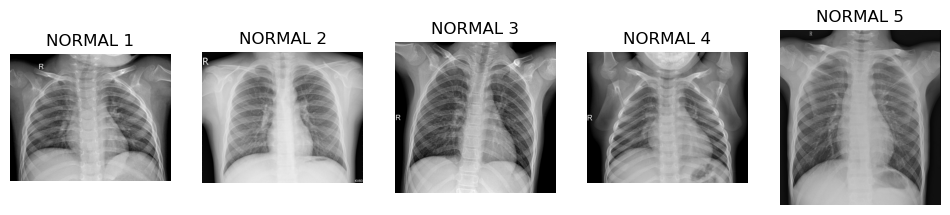

In [148]:
report_data.plot_samples(category_type=ClassDataType.NORMAL)

#### Imagens com covid

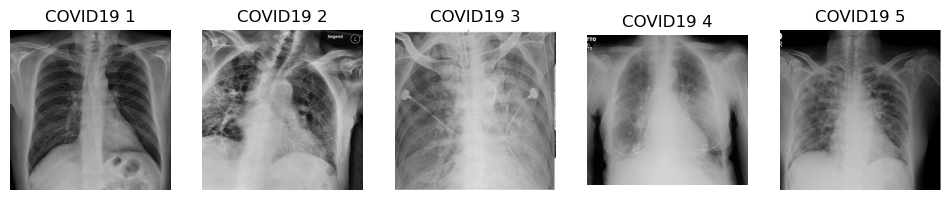

In [149]:
report_data.plot_samples(category_type=ClassDataType.COVID19)

#### Imagens pneumonia

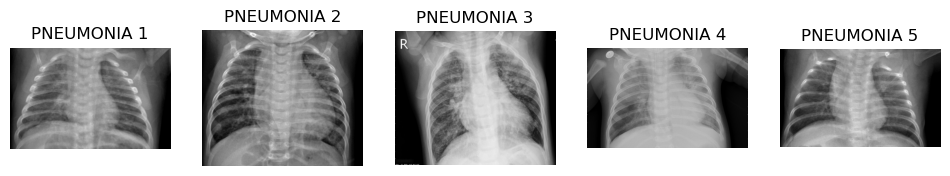

In [150]:
report_data.plot_samples(category_type=ClassDataType.PNEUMONIA)

In [151]:
#### Criando os dataloaders

In [152]:
data_handler = DataHandler(config_instance)
dataloaders = {
    "train": data_handler.train_loader,
    "test": data_handler.test_loader,
    "val": data_handler.val_loader
}
num_classes = len(data_handler.class_names)

Datasets criados. Classes: ['COVID19', 'NORMAL', 'PNEUMONIA']
Tamanho do treino: 4115, Teste: 1029, Validação: 1288
DataLoaders criados com sucesso.


/home/hygo2025/miniconda3/envs/conda_recs/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [153]:
#### Verificando se os dados continuam com a mesma cara.

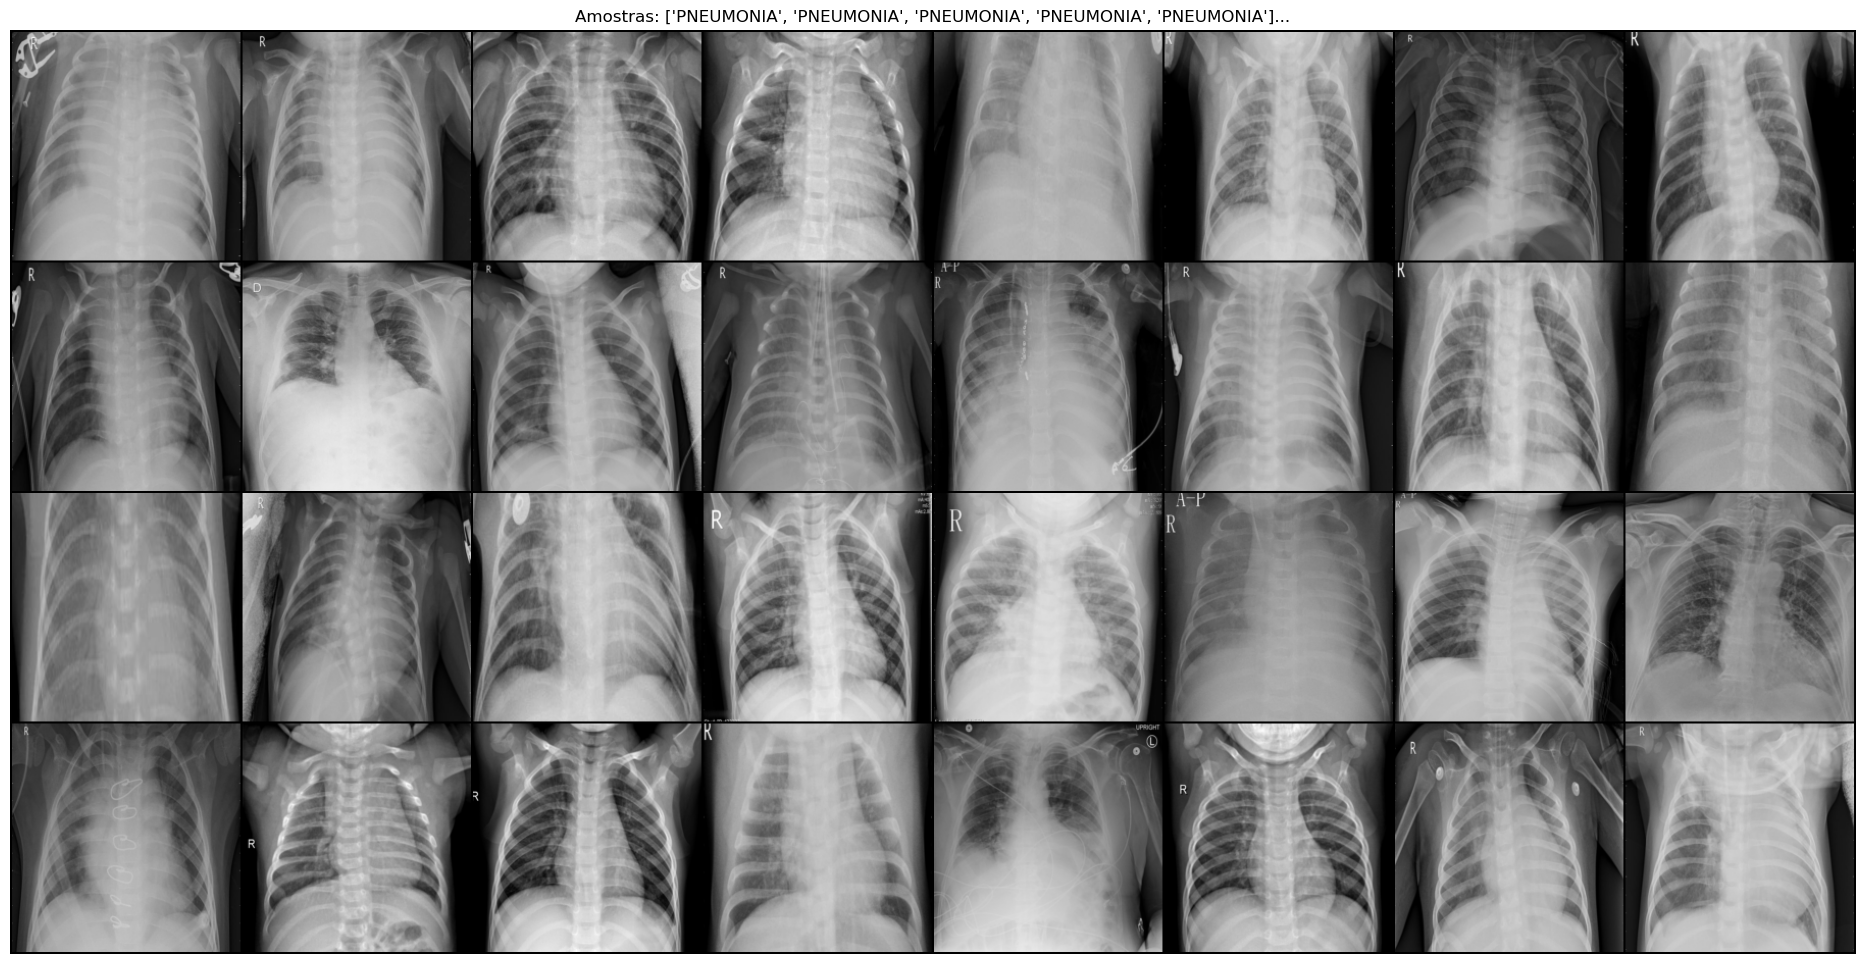

In [154]:
report_data.print_grid(class_names=data_handler.test_dataset_original.classes, data_loader=data_handler.train_loader_original)

### Checando disponibilidade de cuda

In [155]:
import torch

if torch.cuda.is_available():
    print("CUDA está disponível! Treinamento usará a GPU.")
    print("Dispositivo CUDA:", torch.cuda.get_device_name(0))
    print("Versão do PyTorch:", torch.__version__)
    print("Versão do CUDA que o PyTorch foi compilado:", torch.version.cuda)
else:
    print("CUDA NÃO está disponível. Treinamento usará a CPU.")


CUDA está disponível! Treinamento usará a GPU.
Dispositivo CUDA: NVIDIA GeForce RTX 4090
Versão do PyTorch: 2.5.1
Versão do CUDA que o PyTorch foi compilado: 12.4


## Testando o quanto demora para iterar sob o conjunto de dados

Estava demorando muito para enviar os dados para a gpu, dai eu fiz o preprocessamento das imagens para deixar isso mais rapido e com o teste abaixo consigo garantir que essa parte nao vai demorar

In [156]:
import time

print("benchmark do DataLoader...")
start_time = time.time()

for batch in dataloaders['train']:
    pass

end_time = time.time()
print(f"time para percorrer todo o DataLoader: {end_time - start_time:.2f} segundos.")

benchmark do DataLoader...
time para percorrer todo o DataLoader: 11.63 segundos.


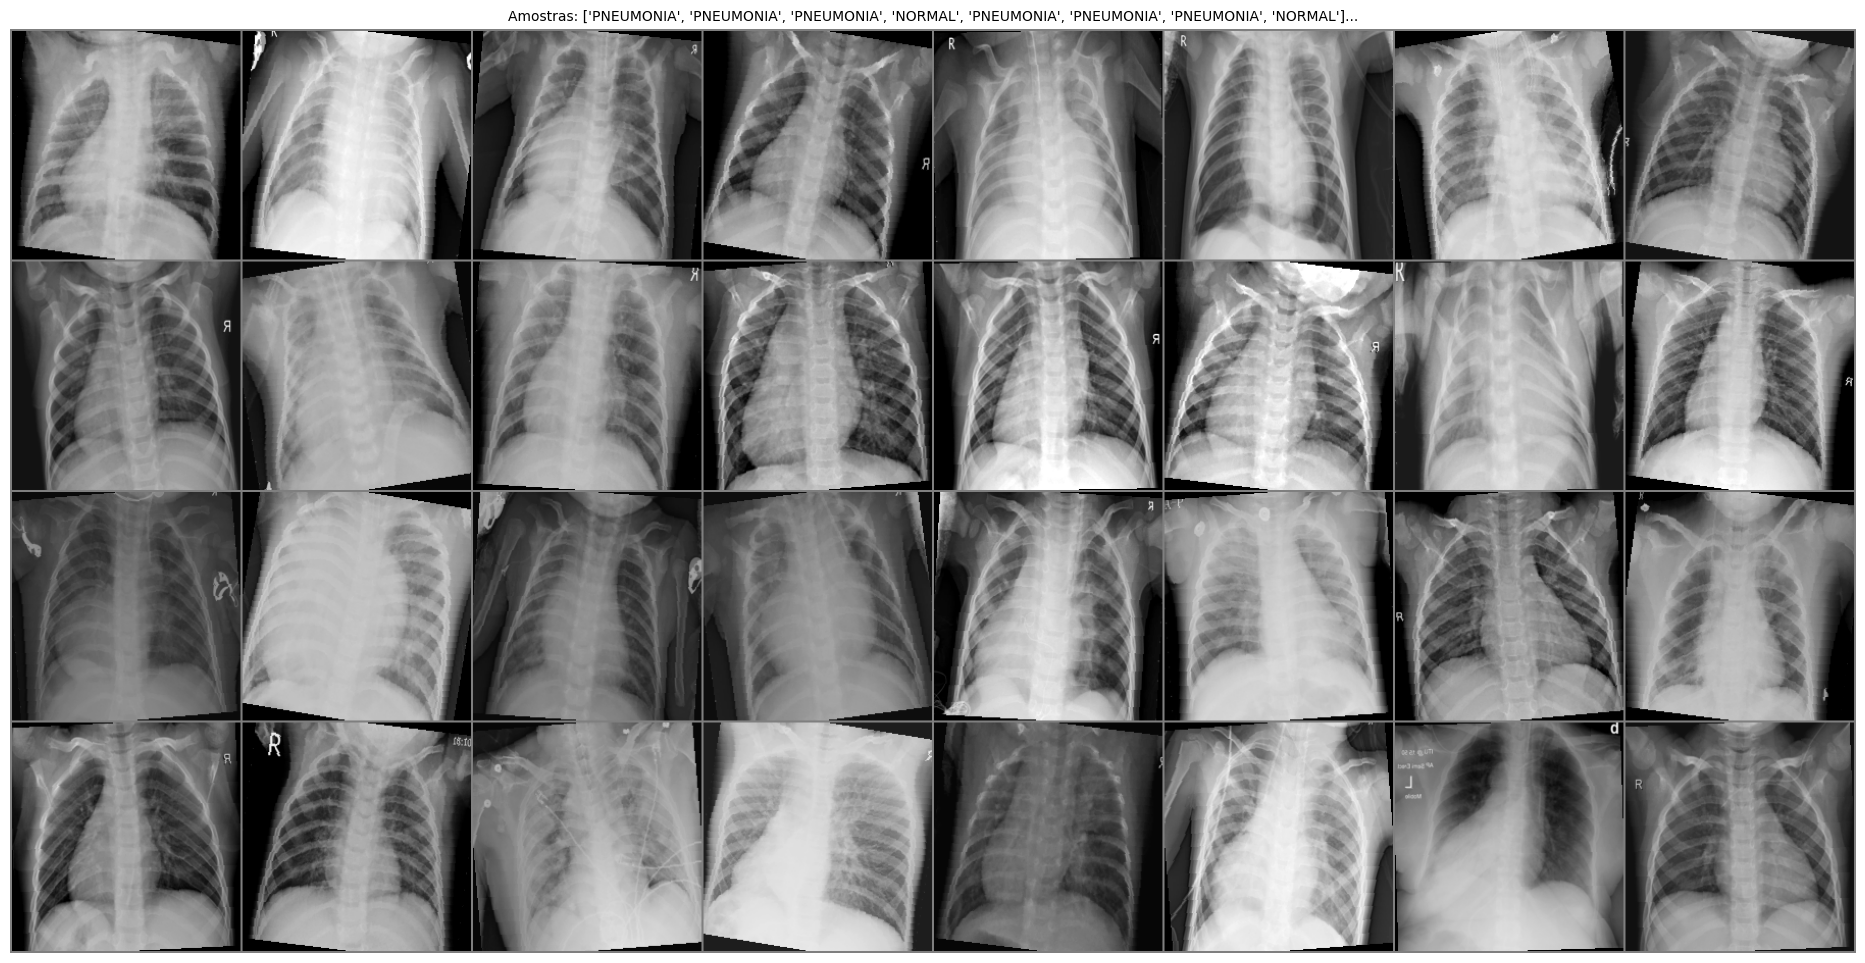

In [157]:
report_data.print_normalized_images(class_names=data_handler.class_names, data_loader=data_handler.train_loader)

## Criando a minha rede

In [158]:
model = Net(num_classes=3)
model.to(config_instance.DEVICE)
model = torch.compile(model)

### Tesntando minha rede para um tensor dummy

In [159]:
dummy_input = torch.randn(1, 3, 224, 224).to(config_instance.DEVICE)

output = model(dummy_input)

print(f"Shape da entrada: {dummy_input.shape}")
print(f"Shape da saída: {output.shape}")
print(f"Saída (logits): {output}")

Shape do tensor antes do flatten: torch.Size([1, 64, 28, 28])
[batch_size, canais, altura, largura] - multiplicar tudo, exceto o batch_size
Shape da entrada: torch.Size([1, 3, 224, 224])
Shape da saída: torch.Size([1, 3])
Saída (logits): tensor([[-0.1749,  0.0434, -0.1071]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)


## A minha base é bem desbalanceada entao vou balancear os pesos

In [160]:
class_weights = config_instance.class_weights_train()
class_weights

Covid: 460, Normal: 1266, Pneumonia: 3418


tensor([0.6676, 0.2426, 0.0898], device='cuda:0')

In [161]:
#https://docs.pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html

import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import time

loss_fn = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(params=model.parameters(), lr=config_instance.learning_rate)

experiment_name = f"SimpleCNN_LR_001_{int(time.time())}"
writer = SummaryWriter(log_dir=f"runs/{experiment_name}")

print(f"Iniciando experimento: {experiment_name}")
print(f"Logs do TensorBoard serão salvos em: runs/{experiment_name}")

Iniciando experimento: SimpleCNN_LR_001_1753126430
Logs do TensorBoard serão salvos em: runs/SimpleCNN_LR_001_1753126430


In [162]:
trainer = Trainer(
    model=model,
    dataloaders=dataloaders,
    loss_fn=loss_fn,
    optimizer=optimizer,
    config=config_instance,
    experiment_name=experiment_name,
    writer=writer
)


In [ ]:
trainer.train()

Epoch 1 | train loss: 0.5242 | train Acc: 0.7570 | test loss: 0.3665 | test Acc: 0.8678
Epoch 2 | train loss: 0.3318 | train Acc: 0.8642 | test loss: 0.3038 | test Acc: 0.9271
Epoch 3 | train loss: 0.2928 | train Acc: 0.8714 | test loss: 0.2750 | test Acc: 0.9291
Epoch 4 | train loss: 0.2392 | train Acc: 0.9009 | test loss: 0.2083 | test Acc: 0.9368
Epoch 5 | train loss: 0.2284 | train Acc: 0.9115 | test loss: 0.1869 | test Acc: 0.9281
Epoch 6 | train loss: 0.1963 | train Acc: 0.9130 | test loss: 0.2153 | test Acc: 0.9213
Epoch 7 | train loss: 0.2011 | train Acc: 0.9159 | test loss: 0.1687 | test Acc: 0.9417
Epoch 8 | train loss: 0.1770 | train Acc: 0.9232 | test loss: 0.1950 | test Acc: 0.9495
Epoch 9 | train loss: 0.1789 | train Acc: 0.9232 | test loss: 0.1675 | test Acc: 0.9203
Epoch 10 | train loss: 0.1607 | train Acc: 0.9239 | test loss: 0.1703 | test Acc: 0.9310
Epoch 11 | train loss: 0.1870 | train Acc: 0.9137 | test loss: 0.1315 | test Acc: 0.9514
Epoch 12 | train loss: 0.1420 